In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Pytorch stuffs
import torch, time
from torch.utils import data

# sklearn utils
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import NN_func

import tensorflow as tf
import wbml.out as out
from varz.spec import parametrised, Positive
from varz.tensorflow import Vars, minimise_l_bfgs_b
from wbml.plot import tweak

from stheno.tensorflow import B, Measure, GP, EQ, Delta, Linear

# CUDA for PyTorch : if we have a GPU, we can use it
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Running on {}".format(device))

Running on cpu


### Data importation

In [2]:
#we import observed data already saved in h5py files and divide it into three subsets
X_train, y_train, X_valid, y_valid, X_test, y_test = NN_func.open_data(vec=True)

X_scaler = StandardScaler() #we create a X_scaler to switch between scaled and unscaled X data
X_scaler.fit(X_train.reshape(-1,1))

x_obs = np.concatenate((X_train,X_valid,X_test))
y_obs = np.concatenate((y_train,y_valid,y_test))

#we import scaled observed data already saved in h5py files and divide it into three subsets
X_train_sc, y_train_sc, X_valid_sc, y_valid_sc, X_test_sc, y_test_sc = NN_func.open_data(vec=True, sc=True)

C:\Users\barba\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### True functions 

In [13]:
x = B.linspace(0, 10, 100)

# the latent functions
y1 = np.sin(x*2.)+ 0.2*x+2. +0.2*(x-5)**2

# the final function
y2 = -4.5+2*y1

C:\Users\barba\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### GP model and predictions

In [16]:
#we initialize a GP with parameters to optimize
@parametrised
def model(
    vs,
    u_var: Positive = 100.,
    u_var2: Positive = 100,
    u_scale: Positive = 1,
    u_scale2: Positive = 10,
    noise: Positive = 0.1,
):
    with Measure():
        f = u_var*GP(EQ()).stretch(u_scale) + u_var2*GP(Linear()).stretch(u_scale2) # Construct Gaussian process.
        f2 = -4.5+tf.cast(2.0, tf.float64)*f
        
    return f, f2, noise

vs = Vars(tf.float64)
f, f2, noise = model(vs)
out.kv("Prior", f2.display(out.format))

def objective(vs):
    f, f2, noise = model(vs)
    evidence = f2(x_obs, noise).logpdf(y_obs)
    return -evidence

# Learn hyperparameters.
minimise_l_bfgs_b(objective, vs, jit=True)
f, f2, noise = model(vs)

# Print the learned parameters.
out.kv("Prior", f2.display(out.format))
vs.print()

# Condition on the observations to make predictions.
f2_post = f2 | (f2(x_obs, noise), y_obs)
f_post = f | (f2(x_obs, noise), y_obs)

# Final predictions with their confidence interval
mean, lower, upper = f_post(x).marginal_credible_bounds()
mean2, lower2, upper2 = f2_post(x).marginal_credible_bounds()

C:\Users\barba\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Prior:      GP(-4.5 * 1, 4.0 * (1.000e+04 * (EQ() > 1.0) + 1.000e+04 * (Linear() > 10.0)))
Prior:      GP(-4.5 * 1, 4.0 * (13.05 * (EQ() > 1.412) + 689.7 * (Linear() > 38.08)))
u_var:      3.612
u_var2:     26.26
u_scale:    1.412
u_scale2:   38.08
noise:      0.08104


### NN model and predictions

In [14]:
#hyperparameters of the NN
nb_layers = 4
nb_neurons = 250
p_drop = 0.01

name='./nn_bcandi/l4_n250_p0.01_m2.pth'

neuralmodel = NN_func.Feedforward(1, nb_neurons, nb_layers, p_drop=p_drop)
neuralmodel.load_state_dict(torch.load(name, map_location='cpu')) #we import a model already trained, the best one
neuralmodel.eval()


nb_predi = 100 #we chose a number of predictions for the dropout method

y1_predi = np.zeros((len(x), nb_predi))
y2_predi = np.zeros((len(x), nb_predi))

neuralmodel.train() # release dropout for pseudo-Bayesian predictions
with torch.no_grad():
        for i in range(nb_predi): #loop for predictions
            y1_predi[:,i] = neuralmodel.Y1_latent_pred(torch.FloatTensor(X_scaler.transform(x.reshape(-1,1))))
            y2_predi[:,i] = neuralmodel.forward(torch.FloatTensor(X_scaler.transform(x.reshape(-1,1))))

C:\Users\barba\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Figures for comparaisons between predictions

C:\Users\barba\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


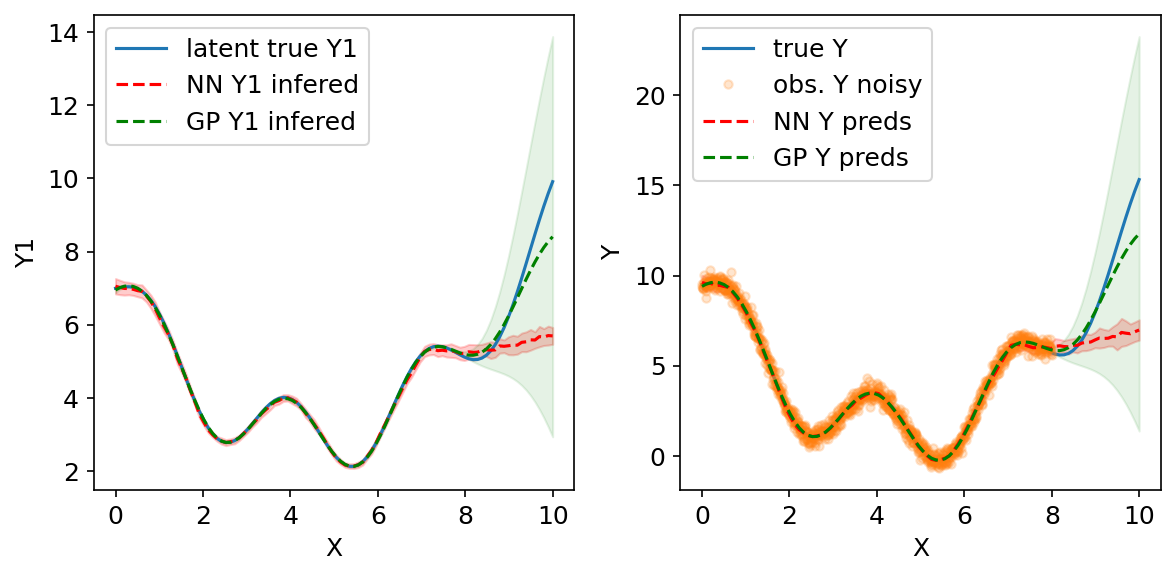

In [24]:
plt.figure(figsize=(8,4), dpi=150)

plt.subplot(121)
plt.plot(x,y1,label="latent true Y1")            
plt.plot(x, np.mean(y1_predi, axis=1), 'r--', label="NN Y1 infered")
plt.fill_between(x, 
                 np.mean(y1_predi, axis=1) - np.std(y1_predi, axis=1),
                np.mean(y1_predi, axis=1) + np.std(y1_predi, axis=1), alpha=0.2,color='r')
plt.plot(x, mean, "--", color="g", label="GP Y1 infered")
plt.fill_between(x, lower, upper, color="g", alpha = 0.1)
plt.xlabel("X")
plt.ylabel('Y1')
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(x,y2,label="true Y")
plt.plot(x_obs,y_obs,'o',color="C1",label="obs. Y noisy",ms=4, alpha=0.2)
plt.plot(x, np.mean(y2_predi, axis=1),"r--",label="NN Y preds")
plt.fill_between(x, 
                 np.mean(y2_predi, axis=1) - np.std(y2_predi, axis=1),
                np.mean(y2_predi, axis=1) + np.std(y2_predi, axis=1), alpha=0.2, color='r')
plt.plot(x, mean2, 'g--', label="GP Y preds")
plt.fill_between(x, lower2, upper2, color='g', alpha=0.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\barba\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


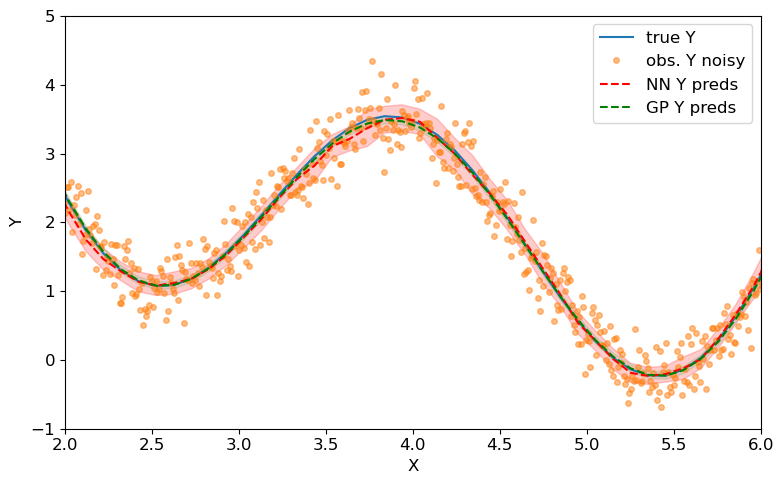

In [25]:
xlg = 2
xld = 6
ylb = -1
ylh = 5


plt.figure(figsize=(8,5), dpi=100)
plt.plot(x,y2,label="true Y")
plt.plot(x_obs,y_obs,'o',color="C1",label="obs. Y noisy",ms=4, alpha=0.5)
plt.plot(x, np.mean(y2_predi, axis=1),"r--",label="NN Y preds")
plt.fill_between(x, 
                 np.mean(y2_predi, axis=1) - np.std(y2_predi, axis=1),
                np.mean(y2_predi, axis=1) + np.std(y2_predi, axis=1), alpha=0.2, color='r')
plt.plot(x, mean2, 'g--', label="GP Y preds")
plt.fill_between(x, lower2, upper2, color='g', alpha=0.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim(xlg,xld)
plt.ylim(ylb,ylh)
plt.show()

C:\Users\barba\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


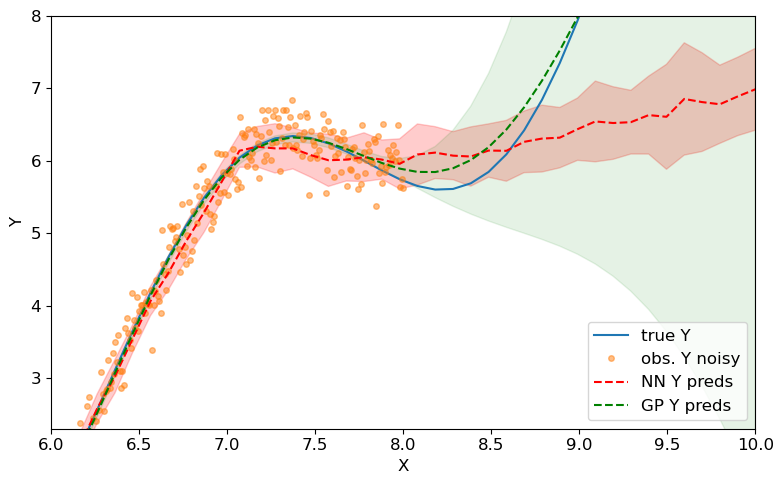

In [26]:
xlg = 6
xld = 10
ylb = 2.3
ylh = 8

plt.figure(figsize=(8,5), dpi=100)
plt.plot(x,y2,label="true Y")
plt.plot(x_obs,y_obs,'o',color="C1",label="obs. Y noisy",ms=4, alpha=0.5)
plt.plot(x, np.mean(y2_predi, axis=1),"r--",label="NN Y preds")
plt.fill_between(x, 
                 np.mean(y2_predi, axis=1) - np.std(y2_predi, axis=1),
                np.mean(y2_predi, axis=1) + np.std(y2_predi, axis=1), alpha=0.2, color='r')
plt.plot(x, mean2, 'g--', label="GP Y preds")
plt.fill_between(x, lower2, upper2, color='g', alpha=0.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim(xlg,xld)
plt.ylim(ylb,ylh)
plt.show()